## Dropout approch to track uncertainity in prediction aletroic and epistemic.
this notebook is based on the below paper:

# Dropout as a Bayesian approximaion

https://arxiv.org/pdf/1506.02142.pdf

In [1]:
# Importing required packages
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout,concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

In [2]:
#drop out model built in tensorflow
def dropout(layers_shape, input_dim, output_dim, dropout_proba, reg, act='relu'):
    inputs = Input(shape=(input_dim,))
    hidden = Dense(layers_shape[0], activation=act,
                   kernel_regularizer=l2(reg))(inputs)
    for i in range(len(layers_shape)-1):
        if dropout_proba > 0:
          hidden = Dropout(dropout_proba)(hidden, training=True)
        hidden = Dense(layers_shape[i+1], activation=act, kernel_regularizer=l2(reg))(hidden)
    if dropout_proba > 0:
      hidden = Dropout(dropout_proba)(hidden, training=True)
    
    mean = Dense(output_dim,kernel_regularizer=l2(reg)) (hidden)
    std = Dense(output_dim, kernel_regularizer=l2(reg))(hidden)
    outputs = concatenate([mean, std])
    model = Model(inputs, outputs)
    
    return model



In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [4]:
path = 'C:/Users/UI931791/OneDrive - RWE/Project- Load Analyisis/Data/2018_v112-neustadt-dosse-10min.csv'

df = pd.read_csv(path)

In [5]:
x_scaler = StandardScaler()
y_scaler = StandardScaler()

In [6]:
x_headers = ['BladeLoadA_max','BladeLoadA_sd','WindSpeed_max','WindSpeed_sd','PowerActive_max','PowerActive_sd',
            'NacelleAccX_max','NacelleAccY_max','NacelleAccX_sd','NacelleAccY_sd','ThetaA_max','ThetaA_sd']
y_headers = ['MYTB_del_m4','MZTB_del_m4','MYTM_del_m4','MZTM_del_m4','MYTT_del_m4','MZTT_del_m4']

# y_headers = ['MYTB_del_m4']

In [7]:
x_norm = x_scaler.fit_transform(df[x_headers])
y_norm = y_scaler.fit_transform(df[y_headers])

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(x_norm, y_norm,test_size=0.4,shuffle=True)

X_shape = X_train.shape[-1]
Y_shape = Y_train.shape[-1]

In [9]:
#loss function
def heteroscedastic_loss(true,pred):
    mean = pred[:, :Y_shape]
    log_var = pred[:, Y_shape:]
    precision = K.exp(-log_var)
        
    return K.sum(precision * (true - mean) ** 2. + log_var, -1)

In [10]:
#hyper parameters
no_layers = 100
topology_core = [no_layers for i in range(3)]
model = dropout(topology_core,X_shape,Y_shape ,dropout_proba = 0.05,reg=0.00475, act='relu' )


In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 12)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 100)          1300        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 100)          0           dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          10100       dropout[0][0]                    
______________________________________________________________________________________________

In [12]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate = 0.001)
batchsize = 50
epoch = 500
model.compile(optimizer = opt,loss= heteroscedastic_loss)

In [13]:
model.fit(X_train,Y_train,batch_size = batchsize,epochs = epoch,verbose = 'auto')

Epoch 1/500
353/353 [==============================] - 4s 4ms/step - loss: -7.7593
Epoch 2/500
353/353 [==============================] - 1s 4ms/step - loss: -12.3758
Epoch 3/500
353/353 [==============================] - 1s 4ms/step - loss: -13.5662
Epoch 4/500
353/353 [==============================] - 1s 3ms/step - loss: -14.2003
Epoch 5/500
353/353 [==============================] - 1s 3ms/step - loss: -14.5842
Epoch 6/500
353/353 [==============================] - 1s 3ms/step - loss: -14.7937
Epoch 7/500
353/353 [==============================] - 1s 4ms/step - loss: -15.0938
Epoch 8/500
353/353 [==============================] - 1s 4ms/step - loss: -15.2866
Epoch 9/500
353/353 [==============================] - 1s 3ms/step - loss: -15.3999
Epoch 10/500
353/353 [==============================] - 1s 4ms/step - loss: -15.5220
Epoch 11/500
353/353 [==============================] - 1s 4ms/step - loss: -15.6464
Epoch 12/500
353/353 [==============================] - 1s 4ms/step - loss:

In [14]:
import numpy as np
from scipy.stats import norm


def predictive_interval(model,test,no_samples=500, ci = 0.95):
    
    pred_samples = np.array([model.predict(test) for _ in range(no_samples)])
    
    samples = pred_samples[ : , : , :Y_shape]
    pred = np.mean(samples,axis=0)
    
    std = np.mean(pred_samples[ : , : , Y_shape:],0)
    aletroic_ucn = np.exp(0.5*std)
    epistemic_ucn = np.std(pred_samples[ : , : , :Y_shape],axis = 0)
    
    total_ucn = (aletroic_ucn **2  + epistemic_ucn **2 ) **0.5
    
    q = norm.ppf(0.5*(1 + ci))
    lwr = pred - q * total_ucn
    upr = pred + q * total_ucn
    
    return samples, pred, total_ucn, lwr, upr
    

In [17]:
#This function calculates the PICP and MPIW taking actual(Y_true) and CI

def cal_PICP_MPIW(model,test,y_true,no_samples=500,ci=0.95):
    pred_samples = np.array([model.predict(test) for _ in range(no_samples)])
    
    samples = pred_samples[ : , : , :Y_shape]
    log_var = pred_samples[ : , : , Y_shape:]
    
    q = norm.ppf(0.5*(1 + ci))

    epistemic_ucn = (np.var(samples,0))**0.5
    aletroic_ucn = (np.exp(log_var))**0.5
    pred = samples
    
    total_ucn = (aletroic_ucn **2  + epistemic_ucn **2 ) **0.5
    
    lwr = pred - q * total_ucn
    upr = pred + q * total_ucn
    
    lwr = y_scaler.inverse_transform(lwr)
    upr = y_scaler.inverse_transform(upr)


    K_u = upr > y_true
    K_l = lwr < y_true


    PICP = np.mean(K_u * K_l)
    MPIW=np.round(np.mean(upr - lwr),3)
    
    return PICP,MPIW


In [21]:
samples,pred,total_ucn,lwr,upr = predictive_interval(model,X_test,no_samples=500 , ci = 0.75)

In [22]:
y_true = y_scaler.inverse_transform(Y_test)
PICP,MPIW = cal_PICP_MPIW(model,X_test,y_true,no_samples=500,ci=0.75)

In [23]:
print("PICP:" , PICP)
print("MPIW:" , MPIW)

PICP: 0.7835215099472879
MPIW: 1967.248


In [16]:
pred = y_scaler.inverse_transform(pred)
x_true = x_scaler.inverse_transform(X_test)
y_true = y_scaler.inverse_transform(Y_test)

lwr = y_scaler.inverse_transform(lwr)
upr = y_scaler.inverse_transform(upr)

In [17]:
results = pd.DataFrame()
for _ in range(len(y_headers)):
    results['pred_'+y_headers[_]] = pred[:,_]
    results['actual_'+y_headers[_]] = y_true[:,_]
    results['lwr_'+y_headers[_]] = lwr[:,_]
    results['upr_'+y_headers[_]] = upr[:,_]
    
results['X'] = x_true[:,2]

In [18]:
results = results.sort_values(by = 'X')

In [19]:
def plot_graph(X,y_true,pred,lwr,upr,ax,title):
    
    ax.scatter(X,y_true,color = 'blue',label='actual',linewidth=.001)
    ax.scatter(X,pred,color = 'red',label='predicted',linewidth=.001)
    ax.fill_between(X, lwr, upr,label='uncertainity',alpha=0.2)
    ax.set_title('{} - r2 {:.4f}'.format(title,r2_score(y_true,pred)))
    ax.set_xlabel('WindSpeed_max')
    ax.set_ylabel('DEL')
    ax.grid()
    ax.legend();

In [20]:
results

,pred_MYTB_del_m4,actual_MYTB_del_m4,lwr_MYTB_del_m4,upr_MYTB_del_m4,pred_MZTB_del_m4,actual_MZTB_del_m4,lwr_MZTB_del_m4,upr_MZTB_del_m4,pred_MYTM_del_m4,actual_MYTM_del_m4,...,upr_MZTM_del_m4,pred_MYTT_del_m4,actual_MYTT_del_m4,lwr_MYTT_del_m4,upr_MYTT_del_m4,pred_MZTT_del_m4,actual_MZTT_del_m4,lwr_MZTT_del_m4,upr_MZTT_del_m4,X
8400,3297.556641,3577.976583,1558.055786,5037.057617,6055.918457,4601.324308,3228.879150,8882.956055,1164.339722,1362.917320,...,2962.059814,267.196991,312.593315,132.660782,401.733124,1493.713501,1119.657450,719.395142,2268.031982,3.088
11056,3184.061035,2870.670887,1628.921997,4739.200195,6567.420410,8959.098062,3926.049072,9208.790039,1155.328491,1009.760560,...,3104.194580,299.134613,347.184506,153.864029,444.405243,1747.148315,2068.061246,825.931274,2668.365479,3.396
2835,1067.508423,905.947117,-37.366589,2172.383301,2145.314697,2494.050063,278.017883,4012.611572,307.540680,344.953806,...,1591.882935,95.135582,98.589062,-1.042339,191.313492,495.834869,614.837034,134.195206,857.474243,3.489
5599,3850.231445,3277.147593,1948.848755,5751.614746,6346.953613,5986.596933,3402.203369,9291.701172,1394.666382,1285.529177,...,3038.254150,311.388519,324.696649,161.573196,461.203796,1644.738770,1513.536946,687.556274,2601.921631,3.512
3698,893.486938,1103.611896,-120.333382,1907.308228,1161.963257,1013.126934,-649.724304,2973.648682,273.895172,448.568927,...,1200.457153,53.402363,80.054959,-43.095257,149.899979,255.034561,302.298201,-146.672226,656.741333,3.563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7034,68357.132812,65670.985410,50632.753906,86081.515625,92458.453125,82903.413700,66153.890625,118763.015625,28470.998047,27125.413210,...,51820.496094,3870.865723,3909.574789,2745.736328,4995.995605,10095.566406,8676.497568,6347.832520,13843.300781,23.699
11656,44545.488281,43335.406990,35115.738281,53975.238281,98813.453125,100058.241500,77199.796875,120427.117188,18494.050781,17955.684220,...,52956.949219,3505.750732,3707.864268,2396.340332,4615.161621,9386.570312,9427.942249,6919.812988,11853.327148,24.228
1991,53637.117188,47953.226920,43113.246094,64160.988281,81244.335938,80764.098750,62900.285156,99588.382812,22359.341797,19880.708050,...,43807.914062,3175.489990,3363.025666,2420.693604,3930.286621,9346.457031,9930.510804,6606.624512,12086.289062,24.749
10300,63426.964844,54183.299650,49295.203125,77558.726562,76843.015625,66389.695260,56869.554688,96816.476562,26485.353516,22595.024710,...,43252.988281,3730.018311,3505.529591,2748.840576,4711.196289,9739.287109,10748.479350,6430.638672,13047.935547,25.214


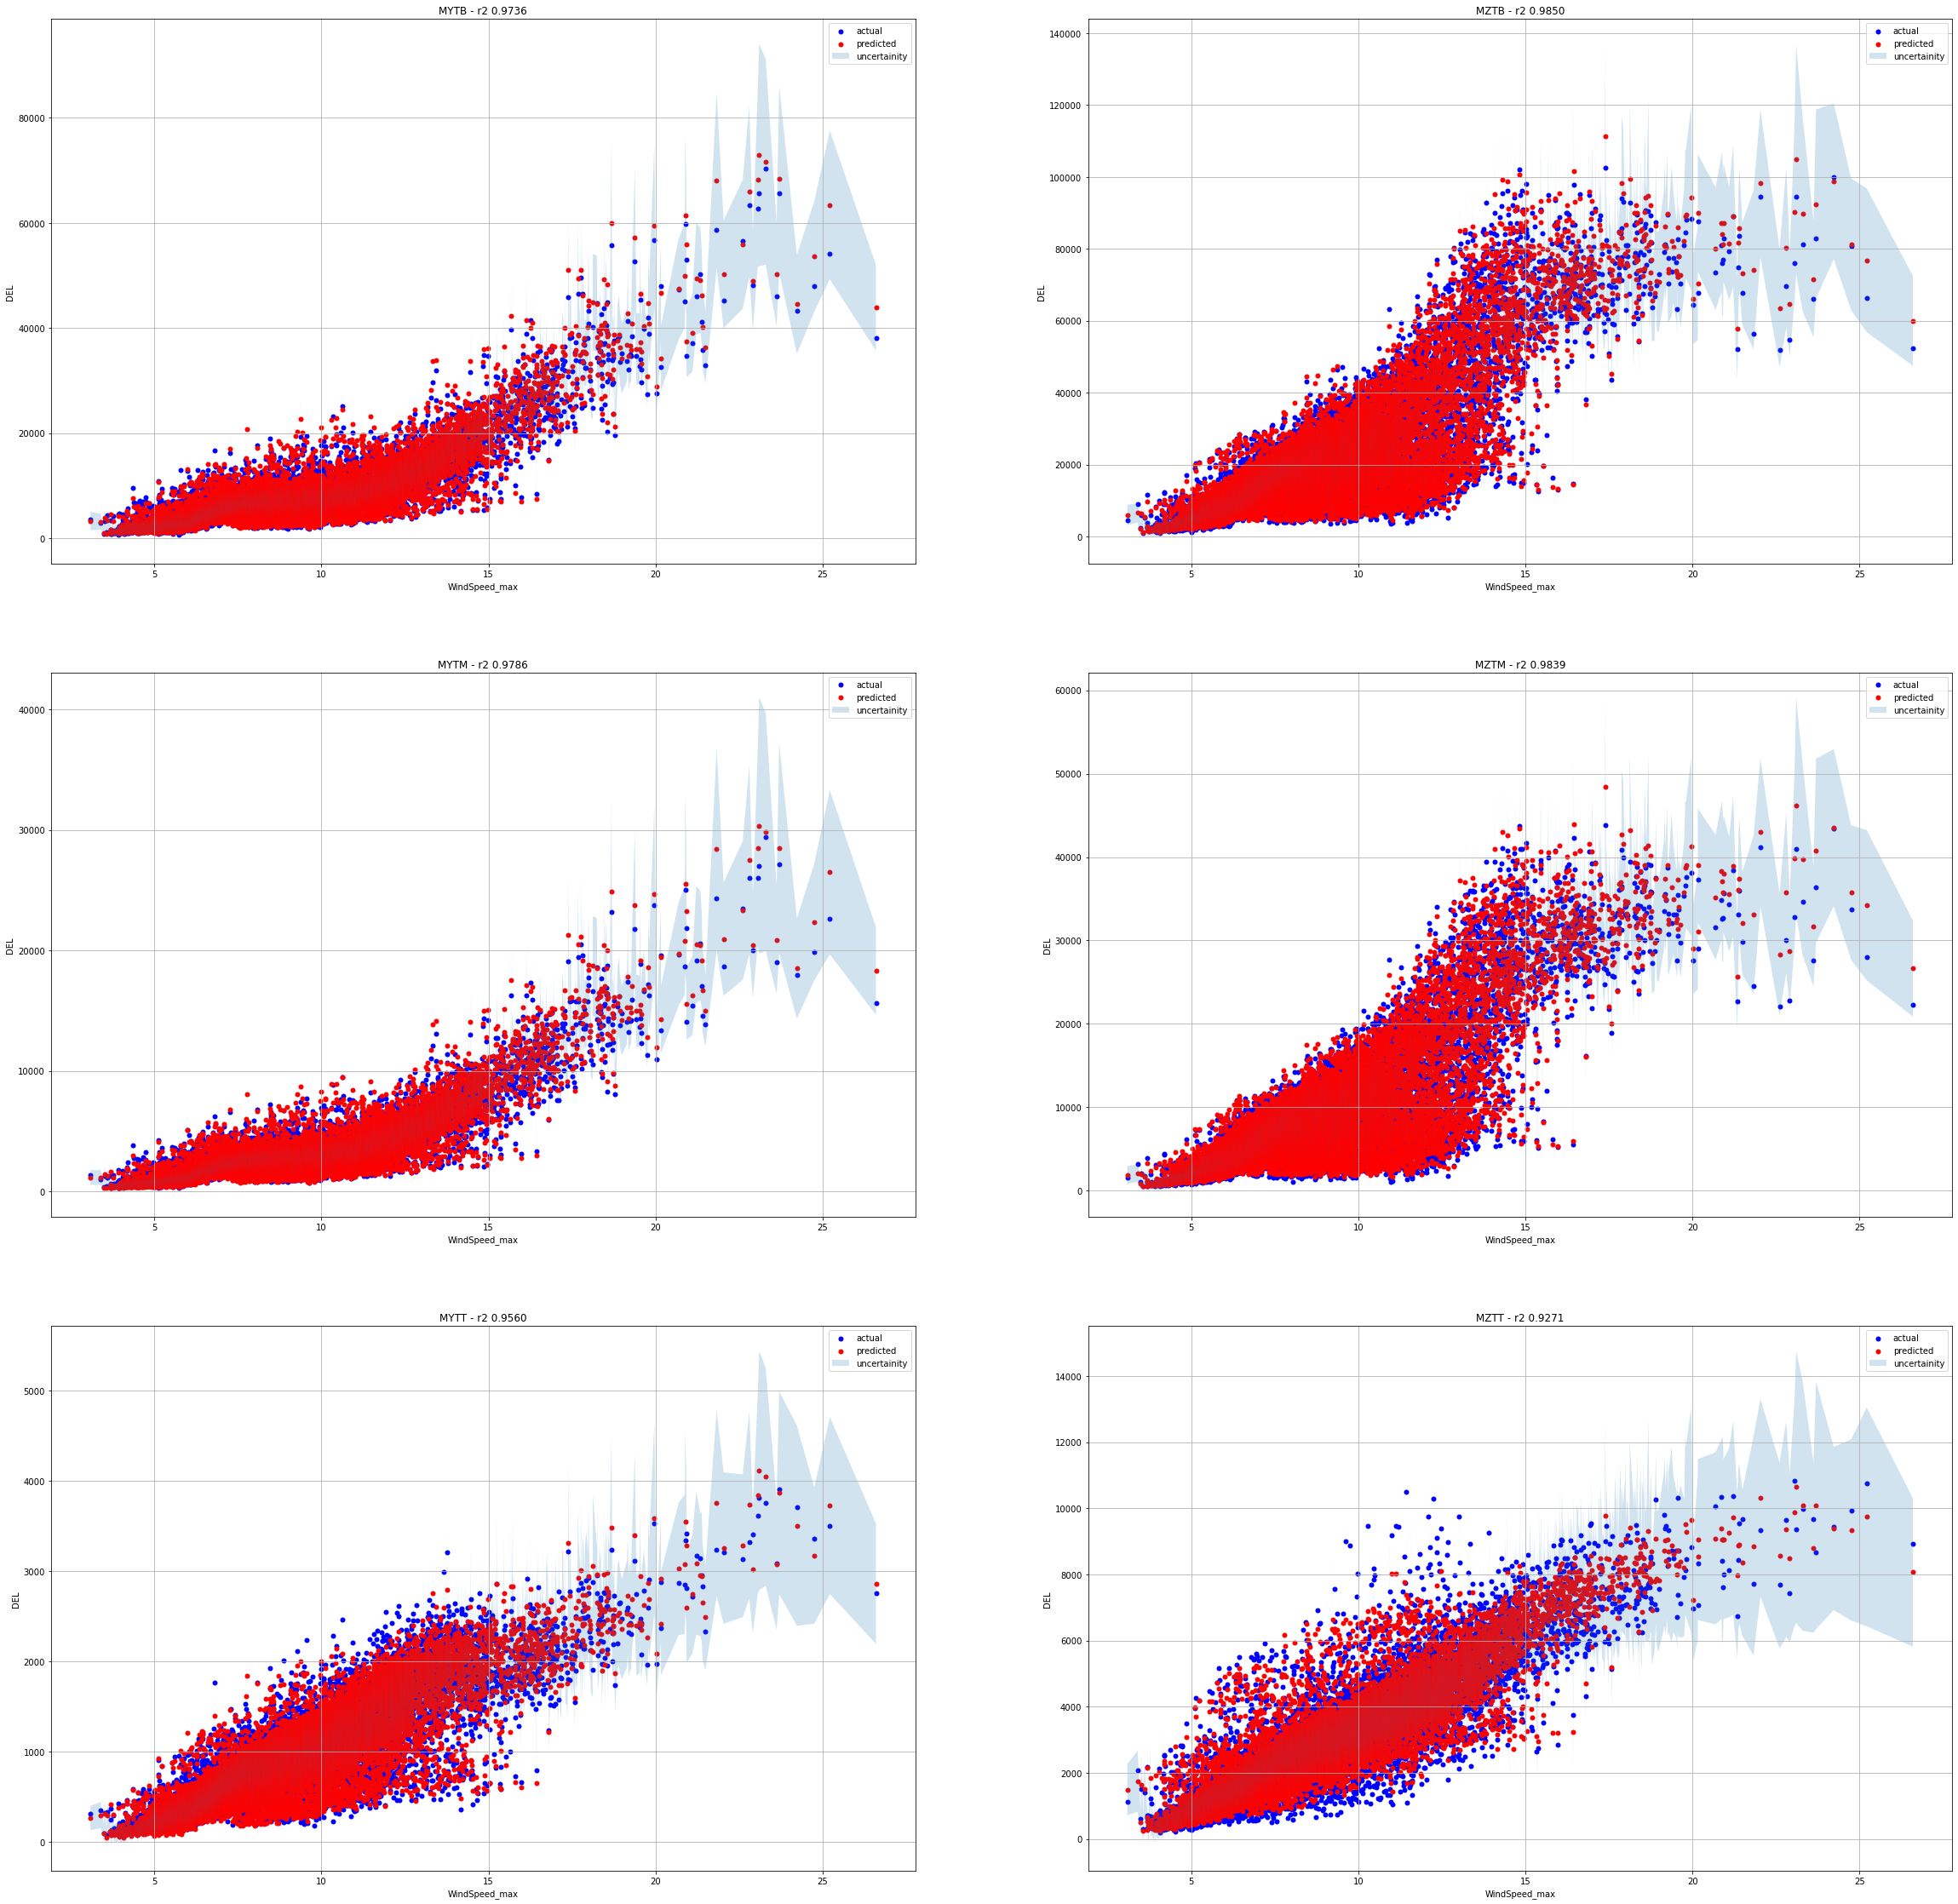

In [21]:
from sklearn.metrics import r2_score

results = results.sort_values(by = 'X')
fig, ax = plt.subplots(3,2,figsize=(40,40))
plot_graph(results['X'],results['actual_MYTB_del_m4'],results['pred_MYTB_del_m4'],results['lwr_MYTB_del_m4'],results['upr_MYTB_del_m4'],ax[0,0],title='MYTB')
plot_graph(results['X'],results['actual_MZTB_del_m4'],results['pred_MZTB_del_m4'],results['lwr_MZTB_del_m4'],results['upr_MZTB_del_m4'],ax[0,1],title='MZTB')
plot_graph(results['X'],results['actual_MYTM_del_m4'],results['pred_MYTM_del_m4'],results['lwr_MYTM_del_m4'],results['upr_MYTM_del_m4'],ax[1,0],title='MYTM')
plot_graph(results['X'],results['actual_MZTM_del_m4'],results['pred_MZTM_del_m4'],results['lwr_MZTM_del_m4'],results['upr_MZTM_del_m4'],ax[1,1],title='MZTM')
plot_graph(results['X'],results['actual_MYTT_del_m4'],results['pred_MYTT_del_m4'],results['lwr_MYTT_del_m4'],results['upr_MYTT_del_m4'],ax[2,0],title='MYTT')
plot_graph(results['X'],results['actual_MZTT_del_m4'],results['pred_MZTT_del_m4'],results['lwr_MZTT_del_m4'],results['upr_MZTT_del_m4'],ax[2,1],title='MZTT')

In [22]:
def woehler_sum(x, m):
    return (np.sum(x**m))**(1/m)

In [23]:
accumalated_load = np.apply_along_axis(woehler_sum,1,samples,m=4)

In [24]:
accumalated_load = y_scaler.inverse_transform(accumalated_load)

In [25]:
measured_load = np.apply_along_axis(woehler_sum,0,Y_test,m=4)

In [26]:
measured_load = y_scaler.inverse_transform(measured_load)

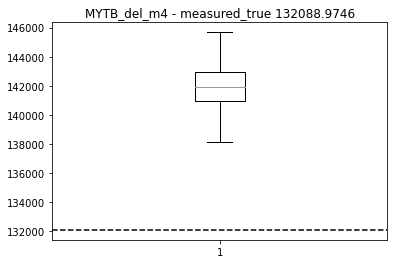

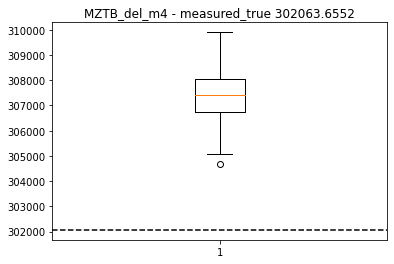

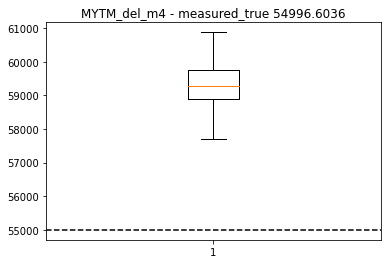

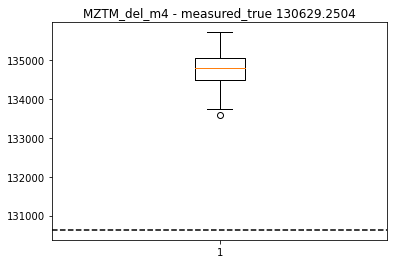

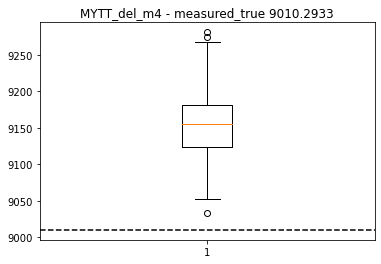

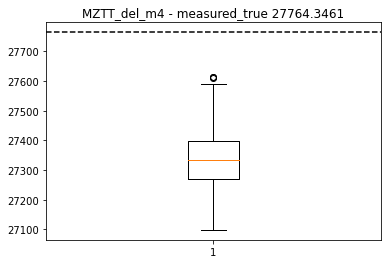

In [27]:
import seaborn as sns
for i in range(len(y_headers)):
    plt.boxplot(accumalated_load[:,i])
    plt.axhline(measured_load[i], ls='--', c='black')
    plt.title('{} - measured_true {:.4f}'.format(y_headers[i],measured_load[i]))
    plt.show()